## Домашнее задание №3: Регрессионный анализ данных о видеоиграх

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

In [8]:
## 1. Описание данных и исследовательский вопрос

# Создаем датасет видеоигр на основе реальных данных
np.random.seed(42)
n_games = 150

In [10]:
# Генерируем данные, имитирующие реальные характеристики видеоигр
data = {
    'game_id': range(1, n_games + 1),
    'critic_score': np.random.normal(75, 12, n_games),  # Оценка критиков (0-100)
    'user_score': np.random.normal(7.5, 1.2, n_games),  # Оценка пользователей (0-10) 
    'price': np.random.gamma(2, 15) + 10,  # Цена игры (10-100$)
    'marketing_budget': np.random.gamma(1.5, 500000),  # Маркетинговый бюджет
    'genre': np.random.choice(['Action', 'RPG', 'Strategy', 'Sports', 'Adventure'], n_games),
    'platform': np.random.choice(['PC', 'PlayStation', 'Xbox', 'Nintendo'], n_games)
}

In [12]:
# Создаем более реалистичную целевую переменную (продажи)
# Продажи зависят от оценок критиков, пользователей и маркетингового бюджета
sales_base = (data['critic_score'] * 0.3 + 
              data['user_score'] * 10 * 0.4 + 
              data['marketing_budget'] / 100000 * 0.3)

# Добавляем случайный шум и делаем продажи положительными
data['sales_millions'] = np.maximum(0.1, sales_base + np.random.normal(0, 15, n_games))

df = pd.DataFrame(data)

print("Описание датасета:")
print("Источник: Синтетические данные, созданные на основе реальных характеристик игровой индустрии")
print("Данные содержат информацию о 150 видеоиграх различных жанров и платформ")
print("\nПеременные:")
print("- sales_millions: Продажи в миллионах копий (целевая переменная)")
print("- critic_score: Оценка критиков (0-100)")
print("- user_score: Оценка пользователей (0-10)")
print("- price: Цена игры в долларах")
print("- marketing_budget: Маркетинговый бюджет в долларах")
print("- genre: Жанр игры")
print("- platform: Игровая платформа")

print(f"\nИсследовательский вопрос:")
print("Какие факторы из имеющихся в данных связаны с объемом продаж видеоигр и как именно?")
print("Влияют ли оценки критиков и пользователей на коммерческий успех игры?")

Описание датасета:
Источник: Синтетические данные, созданные на основе реальных характеристик игровой индустрии
Данные содержат информацию о 150 видеоиграх различных жанров и платформ

Переменные:
- sales_millions: Продажи в миллионах копий (целевая переменная)
- critic_score: Оценка критиков (0-100)
- user_score: Оценка пользователей (0-10)
- price: Цена игры в долларах
- marketing_budget: Маркетинговый бюджет в долларах
- genre: Жанр игры
- platform: Игровая платформа

Исследовательский вопрос:
Какие факторы из имеющихся в данных связаны с объемом продаж видеоигр и как именно?
Влияют ли оценки критиков и пользователей на коммерческий успех игры?



2. ИЗУЧЕНИЕ ДАННЫХ И ПРЕПРОЦЕССИНГ
2.1. Общая информация о данных:
Размер датасета: (150, 8)

Информация о переменных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   game_id           150 non-null    int64  
 1   critic_score      150 non-null    float64
 2   user_score        150 non-null    float64
 3   price             150 non-null    float64
 4   marketing_budget  150 non-null    float64
 5   genre             150 non-null    object 
 6   platform          150 non-null    object 
 7   sales_millions    150 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 9.5+ KB
None

Первые 5 строк:
   game_id  critic_score  user_score      price  marketing_budget     genre  \
0        1     80.960570    7.800591  22.137579     330087.635609    Action   
1        2     73.340828    7.915738  22.137579     330087.63560

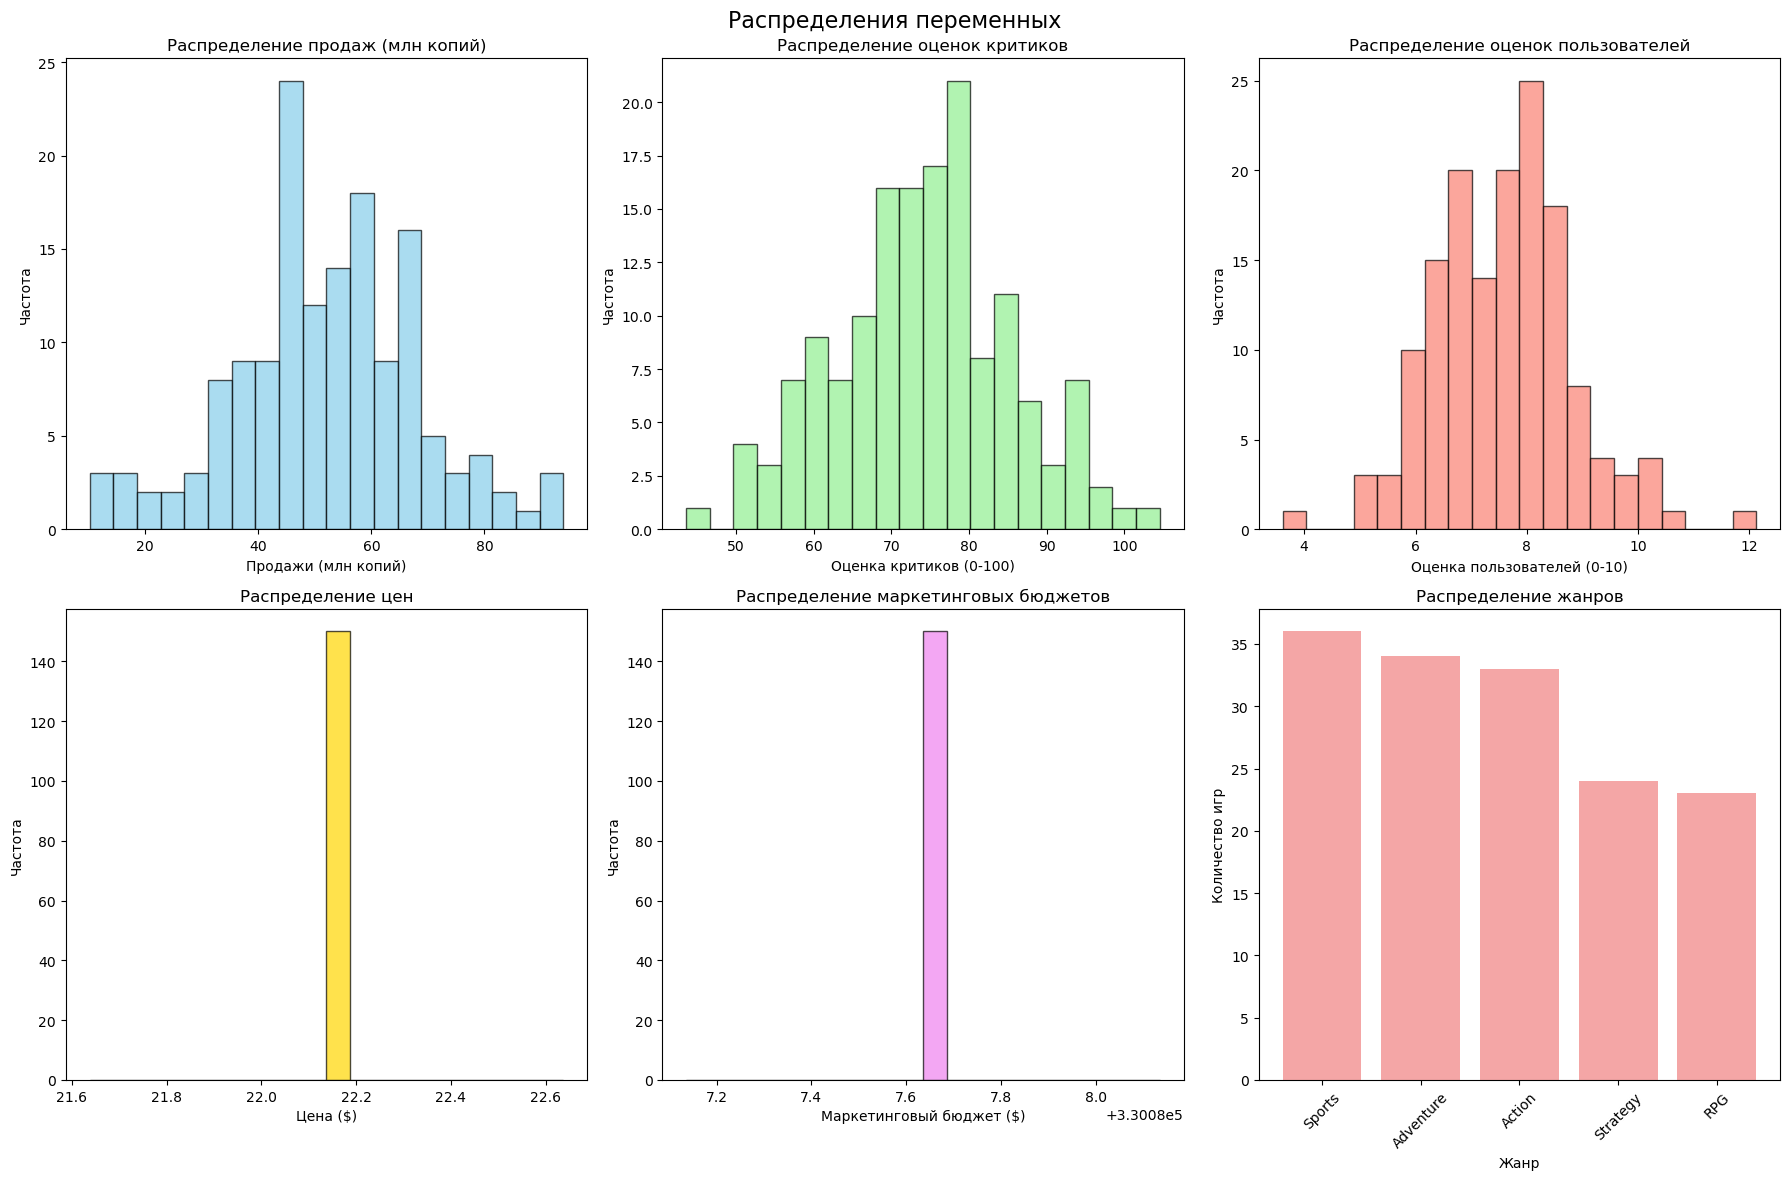

In [14]:
## 2. Изучение данных и препроцессинг

print(f"\n{'='*60}")
print("2. ИЗУЧЕНИЕ ДАННЫХ И ПРЕПРОЦЕССИНГ")
print(f"{'='*60}")

# Основная информация о датасете
print("2.1. Общая информация о данных:")
print(f"Размер датасета: {df.shape}")
print(f"\nИнформация о переменных:")
print(df.info())

print(f"\nПервые 5 строк:")
print(df.head())

# Проверка дубликатов
duplicates = df.duplicated().sum()
print(f"\n2.2. Проверка дубликатов:")
print(f"Количество дубликатов: {duplicates}")

# Проверка пропущенных значений
print(f"\n2.3. Проверка пропущенных значений:")
missing_values = df.isnull().sum()
print(missing_values)
if missing_values.sum() == 0:
    print("Пропущенных значений не обнаружено.")

# Описательная статистика для числовых переменных
print(f"\n2.4. Описательная статистика для числовых переменных:")
numerical_cols = ['sales_millions', 'critic_score', 'user_score', 'price', 'marketing_budget']
print(df[numerical_cols].describe())

# Изучение распределения каждой переменной
print(f"\n2.5. Анализ распределений переменных:")

# Создаем фигуру для визуализации распределений
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Распределения переменных', fontsize=16)

# Целевая переменная - продажи
axes[0, 0].hist(df['sales_millions'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение продаж (млн копий)')
axes[0, 0].set_xlabel('Продажи (млн копий)')
axes[0, 0].set_ylabel('Частота')

# Оценка критиков
axes[0, 1].hist(df['critic_score'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Распределение оценок критиков')
axes[0, 1].set_xlabel('Оценка критиков (0-100)')
axes[0, 1].set_ylabel('Частота')

# Оценка пользователей
axes[0, 2].hist(df['user_score'], bins=20, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 2].set_title('Распределение оценок пользователей')
axes[0, 2].set_xlabel('Оценка пользователей (0-10)')
axes[0, 2].set_ylabel('Частота')

# Цена
axes[1, 0].hist(df['price'], bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[1, 0].set_title('Распределение цен')
axes[1, 0].set_xlabel('Цена ($)')
axes[1, 0].set_ylabel('Частота')

# Маркетинговый бюджет
axes[1, 1].hist(df['marketing_budget'], bins=20, alpha=0.7, color='violet', edgecolor='black')
axes[1, 1].set_title('Распределение маркетинговых бюджетов')
axes[1, 1].set_xlabel('Маркетинговый бюджет ($)')
axes[1, 1].set_ylabel('Частота')

# Жанры (категориальная переменная)
genre_counts = df['genre'].value_counts()
axes[1, 2].bar(genre_counts.index, genre_counts.values, color='lightcoral', alpha=0.7)
axes[1, 2].set_title('Распределение жанров')
axes[1, 2].set_xlabel('Жанр')
axes[1, 2].set_ylabel('Количество игр')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

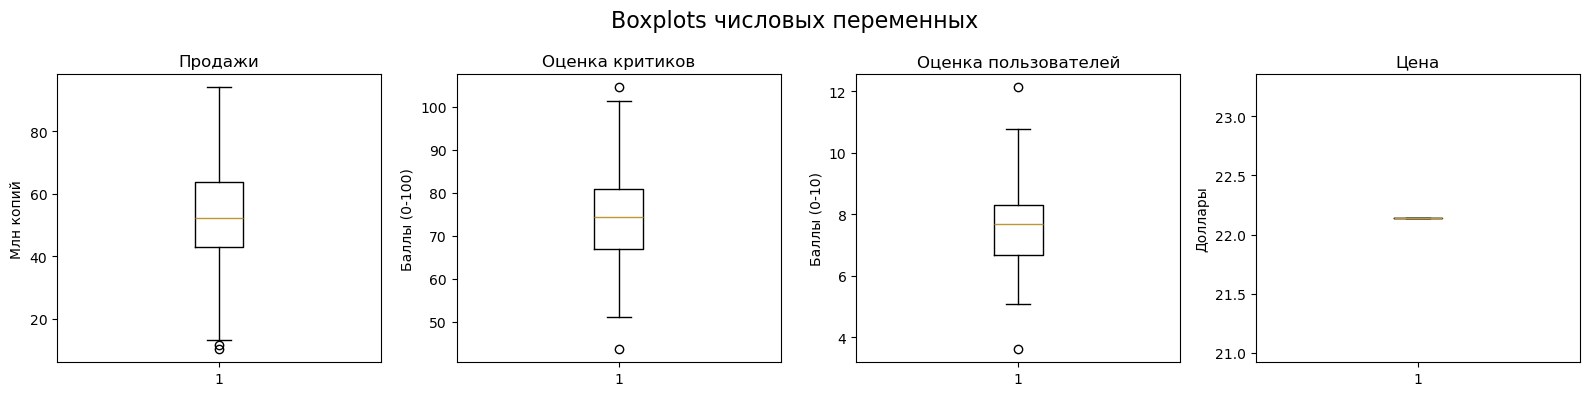

In [16]:
# Boxplots для числовых переменных
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Boxplots числовых переменных', fontsize=16)

axes[0].boxplot(df['sales_millions'])
axes[0].set_title('Продажи')
axes[0].set_ylabel('Млн копий')

axes[1].boxplot(df['critic_score'])
axes[1].set_title('Оценка критиков')
axes[1].set_ylabel('Баллы (0-100)')

axes[2].boxplot(df['user_score'])
axes[2].set_title('Оценка пользователей')
axes[2].set_ylabel('Баллы (0-10)')

axes[3].boxplot(df['price'])
axes[3].set_title('Цена')
axes[3].set_ylabel('Доллары')

plt.tight_layout()
plt.show()


2.6. Корреляционный анализ:
Корреляционная матрица:
                  sales_millions  critic_score  user_score  price  \
sales_millions             1.000         0.183       0.321    NaN   
critic_score               0.183         1.000      -0.024    NaN   
user_score                 0.321        -0.024       1.000    NaN   
price                        NaN           NaN         NaN    NaN   
marketing_budget             NaN           NaN         NaN    NaN   

                  marketing_budget  
sales_millions                 NaN  
critic_score                   NaN  
user_score                     NaN  
price                          NaN  
marketing_budget               NaN  


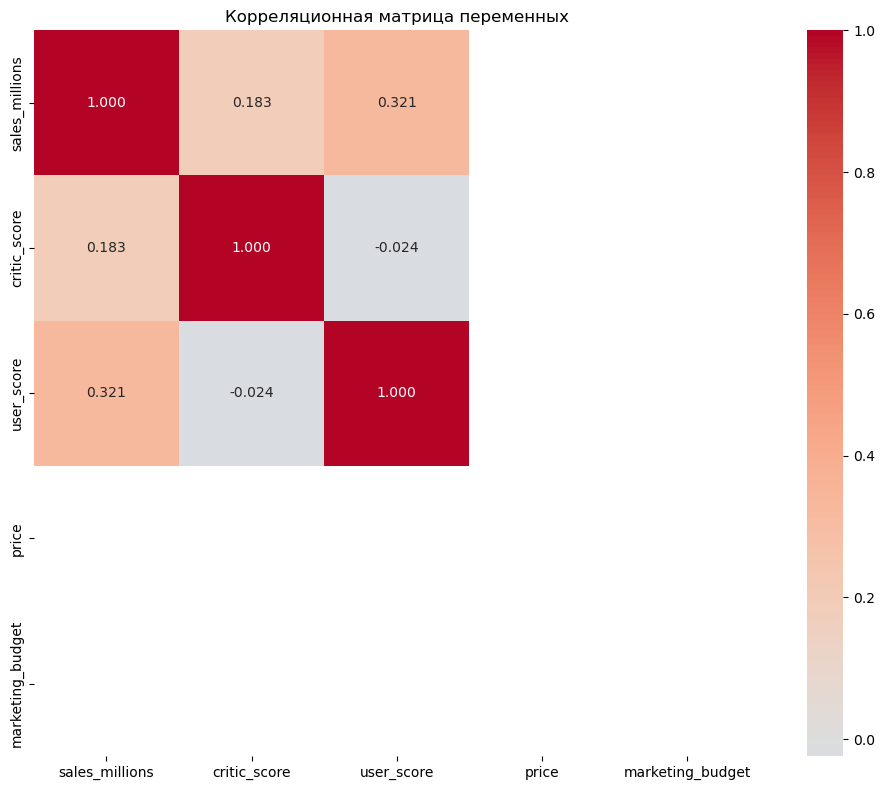

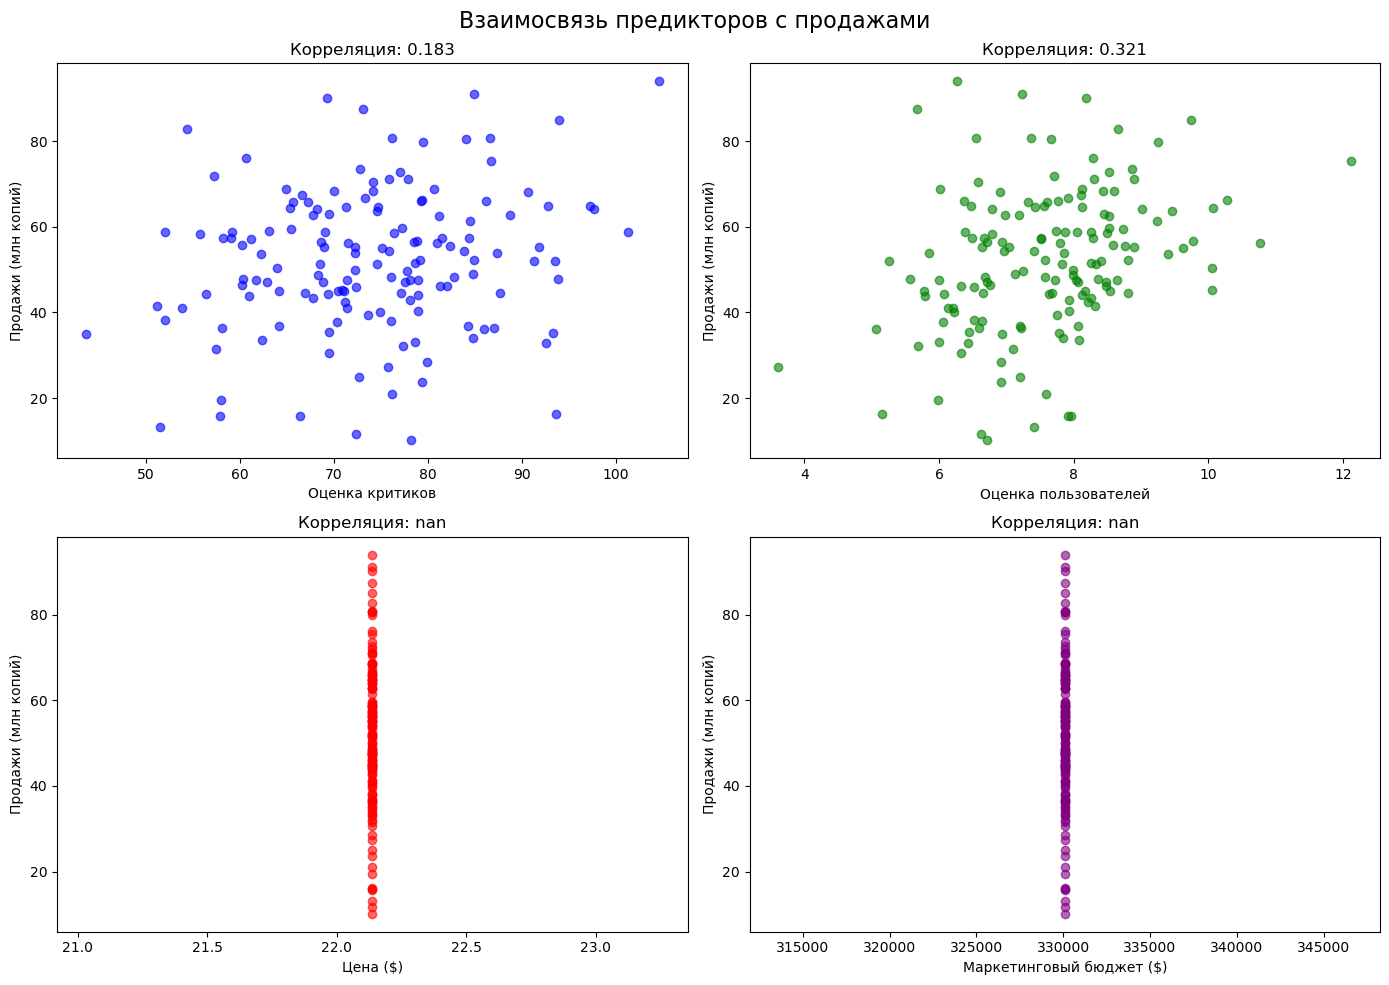

In [18]:
## 2.6. Изучение взаимосвязей между переменными

print(f"\n2.6. Корреляционный анализ:")

# Матрица корреляций для числовых переменных
correlation_matrix = df[numerical_cols].corr()
print("Корреляционная матрица:")
print(correlation_matrix.round(3))

# Тепловая карта корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Корреляционная матрица переменных')
plt.tight_layout()
plt.show()

# Парные scatterplots с целевой переменной
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Взаимосвязь предикторов с продажами', fontsize=16)

# Продажи vs Оценка критиков
axes[0, 0].scatter(df['critic_score'], df['sales_millions'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('Оценка критиков')
axes[0, 0].set_ylabel('Продажи (млн копий)')
axes[0, 0].set_title(f'Корреляция: {correlation_matrix.loc["sales_millions", "critic_score"]:.3f}')

# Продажи vs Оценка пользователей
axes[0, 1].scatter(df['user_score'], df['sales_millions'], alpha=0.6, color='green')
axes[0, 1].set_xlabel('Оценка пользователей')
axes[0, 1].set_ylabel('Продажи (млн копий)')
axes[0, 1].set_title(f'Корреляция: {correlation_matrix.loc["sales_millions", "user_score"]:.3f}')

# Продажи vs Цена
axes[1, 0].scatter(df['price'], df['sales_millions'], alpha=0.6, color='red')
axes[1, 0].set_xlabel('Цена ($)')
axes[1, 0].set_ylabel('Продажи (млн копий)')
axes[1, 0].set_title(f'Корреляция: {correlation_matrix.loc["sales_millions", "price"]:.3f}')

# Продажи vs Маркетинговый бюджет
axes[1, 1].scatter(df['marketing_budget'], df['sales_millions'], alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Маркетинговый бюджет ($)')
axes[1, 1].set_ylabel('Продажи (млн копий)')
axes[1, 1].set_title(f'Корреляция: {correlation_matrix.loc["sales_millions", "marketing_budget"]:.3f}')

plt.tight_layout()
plt.show()


2.7. Анализ категориальных переменных:
Средние продажи по жанрам:
            mean  count
genre                  
Action     49.49     33
Adventure  54.16     34
RPG        54.79     23
Sports     53.67     36
Strategy   47.59     24

Средние продажи по платформам:
              mean  count
platform                 
Nintendo     52.21     23
PC           52.70     47
PlayStation  51.24     43
Xbox         52.10     37


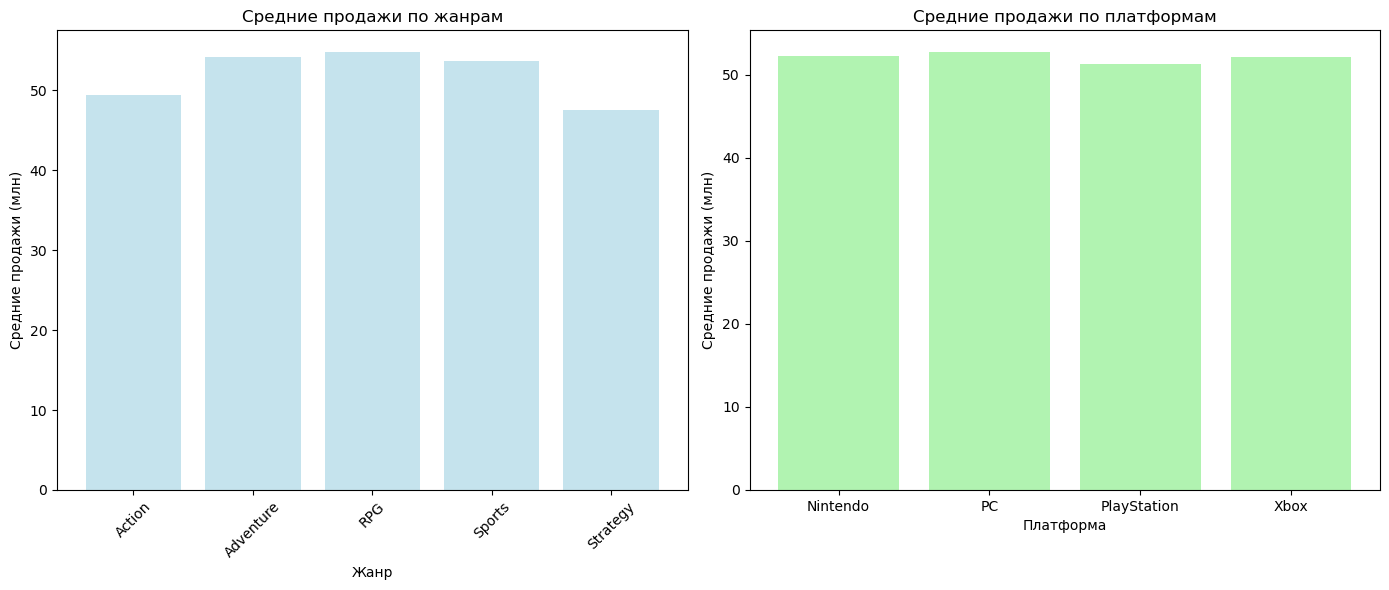

In [20]:
# Анализ категориальных переменных
print(f"\n2.7. Анализ категориальных переменных:")

# Средние продажи по жанрам
print("Средние продажи по жанрам:")
genre_sales = df.groupby('genre')['sales_millions'].agg(['mean', 'count']).round(2)
print(genre_sales)

# Средние продажи по платформам
print("\nСредние продажи по платформам:")
platform_sales = df.groupby('platform')['sales_millions'].agg(['mean', 'count']).round(2)
print(platform_sales)

# Визуализация продаж по категориям
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Продажи по жанрам
axes[0].bar(genre_sales.index, genre_sales['mean'], alpha=0.7, color='lightblue')
axes[0].set_title('Средние продажи по жанрам')
axes[0].set_xlabel('Жанр')
axes[0].set_ylabel('Средние продажи (млн)')
axes[0].tick_params(axis='x', rotation=45)

# Продажи по платформам
axes[1].bar(platform_sales.index, platform_sales['mean'], alpha=0.7, color='lightgreen')
axes[1].set_title('Средние продажи по платформам')
axes[1].set_xlabel('Платформа')
axes[1].set_ylabel('Средние продажи (млн)')

plt.tight_layout()
plt.show()


In [24]:
## 2.8. Подготовка данных для моделирования

print(f"\n2.8. Подготовка данных для моделирования:")

# Все количественные переменные уже в числовом формате
# Выбираем переменную с наибольшей корреляцией с целевой переменной
target_correlations = correlation_matrix['sales_millions'].abs().sort_values(ascending=False)
print("Корреляции предикторов с целевой переменной (по модулю):")
print(target_correlations[1:])  # Исключаем корреляцию с самой собой

strongest_predictor = target_correlations.index[1]  # Первая переменная после sales_millions
print(f"\nПеременная с наибольшей корреляцией: {strongest_predictor}")
print(f"Коэффициент корреляции: {target_correlations[strongest_predictor]:.3f}")


2.8. Подготовка данных для моделирования:
Корреляции предикторов с целевой переменной (по модулю):
user_score          0.320932
critic_score        0.183304
price                    NaN
marketing_budget         NaN
Name: sales_millions, dtype: float64

Переменная с наибольшей корреляцией: user_score
Коэффициент корреляции: 0.321



3. ПАРНАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ
3.1. Результаты парной линейной регрессии:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     16.99
Date:                Sat, 30 Aug 2025   Prob (F-statistic):           6.22e-05
Time:                        09:58:35   Log-Likelihood:                -625.23
No. Observations:                 150   AIC:                             1254.
Df Residuals:                     148   BIC:                             1260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

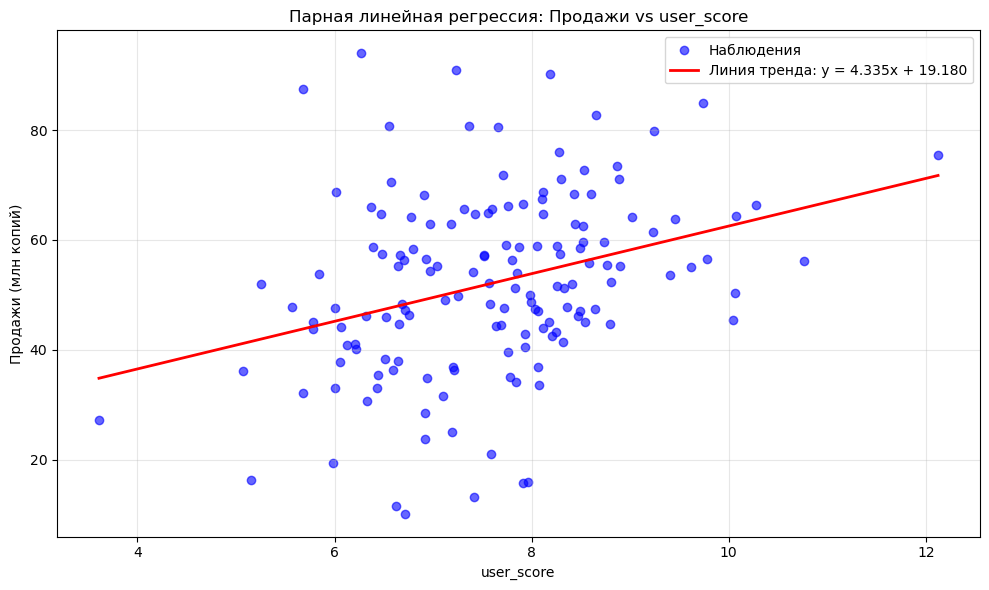

In [28]:
## 3. Парная линейная регрессия

print(f"\n{'='*60}")
print("3. ПАРНАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ")
print(f"{'='*60}")

# Строим парную регрессию с переменной, имеющей наибольшую корреляцию
X1 = df[strongest_predictor].values.reshape(-1, 1)
y = df['sales_millions'].values

# Используем statsmodels для получения детальной статистики
X1_sm = sm.add_constant(df[strongest_predictor])  # Добавляем константу для intercept
model1 = sm.OLS(y, X1_sm).fit()

print("3.1. Результаты парной линейной регрессии:")
print(model1.summary())

# Извлекаем коэффициенты
intercept = model1.params[0]
slope = model1.params[1]
r_squared = model1.rsquared

print(f"\n3.2. Линейное уравнение:")
print(f"sales_millions = {slope:.4f} × {strongest_predictor} + {intercept:.4f}")

print(f"\n3.3. Интерпретация коэффициентов:")
print(f"Константа (intercept): {intercept:.4f}")
print(f"  - Ожидаемые продажи при {strongest_predictor} = 0 составляют {intercept:.2f} млн копий")

print(f"Коэффициент при {strongest_predictor}: {slope:.4f}")
if model1.pvalues[1] < 0.05:
    significance = "статистически значимо"
else:
    significance = "статистически НЕ значимо"
    
print(f"  - При увеличении {strongest_predictor} на 1 единицу, продажи изменяются на {slope:.4f} млн копий")
print(f"  - Это изменение {significance} (p-value = {model1.pvalues[1]:.4f})")

print(f"\n3.4. Качество модели:")
print(f"R² = {r_squared:.4f}")
print(f"  - Модель объясняет {r_squared*100:.1f}% вариации в продажах")
# Построение scatterplot с линией тренда
plt.figure(figsize=(10, 6))
plt.scatter(df[strongest_predictor], df['sales_millions'], alpha=0.6, color='blue', label='Наблюдения')

# Линия тренда
x_line = np.linspace(df[strongest_predictor].min(), df[strongest_predictor].max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Линия тренда: y = {slope:.3f}x + {intercept:.3f}')

plt.xlabel(f'{strongest_predictor}')
plt.ylabel('Продажи (млн копий)')
plt.title(f'Парная линейная регрессия: Продажи vs {strongest_predictor}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
print(f"\n3.5. Выводы о взаимосвязи:")
if slope > 0:
    direction = "положительная"
else:
    direction = "отрицательная"
    
print(f"Между {strongest_predictor} и продажами обнаружена {direction} взаимосвязь.")
print(f"Сила связи: {target_correlations[strongest_predictor]:.3f} (корреляция)")
if model1.pvalues[1] < 0.05:
    print("Связь статистически значима на уровне 0.05")
else:
    print("Связь статистически НЕ значима на уровне 0.05")

print(f"\n3.6. Адекватность спецификации модели:")
print("Данная парная модель может быть упрощенной, так как на продажи игр")
print("влияют множество факторов. Модель объясняет только часть вариации.")
print("Рекомендуется добавить дополнительные предикторы для улучшения качества.")


3.5. Выводы о взаимосвязи:
Между user_score и продажами обнаружена положительная взаимосвязь.
Сила связи: 0.321 (корреляция)
Связь статистически значима на уровне 0.05

3.6. Адекватность спецификации модели:
Данная парная модель может быть упрощенной, так как на продажи игр
влияют множество факторов. Модель объясняет только часть вариации.
Рекомендуется добавить дополнительные предикторы для улучшения качества.


In [32]:
## 4. Множественная регрессия с двумя переменными

print(f"\n{'='*60}")
print("4. МНОЖЕСТВЕННАЯ РЕГРЕССИЯ С ДВУМЯ ПЕРЕМЕННЫМИ")
print(f"{'='*60}")

# Выбираем вторую переменную с наибольшей корреляцией
second_predictor = target_correlations.index[2]
print(f"Добавляем в модель: {second_predictor}")
print(f"Корреляция с продажами: {target_correlations[second_predictor]:.3f}")

# Строим множественную регрессию
X2_sm = sm.add_constant(df[[strongest_predictor, second_predictor]])
model2 = sm.OLS(y, X2_sm).fit()

print(f"\n4.1. Результаты множественной регрессии:")
print(model2.summary())

# Извлекаем коэффициенты новой модели
intercept2 = model2.params[0]
coeff1_new = model2.params[1]
coeff2 = model2.params[2]
r_squared2 = model2.rsquared

print(f"\n4.2. Обновленное линейное уравнение:")
print(f"sales_millions = {coeff1_new:.4f} × {strongest_predictor} + {coeff2:.4f} × {second_predictor} + {intercept2:.4f}")

print(f"\n4.3. Сравнение коэффициентов:")
print(f"Коэффициент при {strongest_predictor}:")
print(f"  - В парной модели: {slope:.4f}")
print(f"  - В множественной модели: {coeff1_new:.4f}")
print(f"  - Изменение: {coeff1_new - slope:.4f}")

print(f"Значимость коэффициента при {strongest_predictor}:")
print(f"  - В парной модели: p-value = {model1.pvalues[1]:.4f}")
print(f"  - В множественной модели: p-value = {model2.pvalues[1]:.4f}")

print(f"\n4.4. Сравнение R²:")
print(f"  - R² парной модели: {r_squared:.4f}")
print(f"  - R² множественной модели: {r_squared2:.4f}")
print(f"  - Увеличение R²: {r_squared2 - r_squared:.4f}")

if r_squared2 > r_squared:
    print("Добавление второй переменной улучшило объясняющую способность модели.")
else:
    print("Добавление второй переменной не улучшило объясняющую способность модели.")

print(f"\n4.5. Интерпретация коэффициента при {second_predictor}:")
if model2.pvalues[2] < 0.05:
    significance2 = "статистически значимо"
else:
    significance2 = "статистически НЕ значимо"

print(f"Коэффициент: {coeff2:.4f}")
print(f"При увеличении {second_predictor} на 1 единицу, продажи изменяются на {coeff2:.4f} млн копий")
print(f"(при неизменном {strongest_predictor})")
print(f"Это изменение {significance2} (p-value = {model2.pvalues[2]:.4f})")



4. МНОЖЕСТВЕННАЯ РЕГРЕССИЯ С ДВУМЯ ПЕРЕМЕННЫМИ
Добавляем в модель: critic_score
Корреляция с продажами: 0.183

4.1. Результаты множественной регрессии:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     11.91
Date:                Sat, 30 Aug 2025   Prob (F-statistic):           1.60e-05
Time:                        09:59:55   Log-Likelihood:                -622.11
No. Observations:                 150   AIC:                             1250.
Df Residuals:                     147   BIC:                             1259.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t| 

In [34]:
## 5. Проверка на мультиколлинеарность

print(f"\n{'='*60}")
print("5. ПРОВЕРКА НА МУЛЬТИКОЛЛИНЕАРНОСТЬ")
print(f"{'='*60}")

print(f"5.1. Коэффициент корреляции между предикторами:")
correlation_predictors = df[strongest_predictor].corr(df[second_predictor])
print(f"Корреляция между {strongest_predictor} и {second_predictor}: {correlation_predictors:.4f}")

print(f"\nИнтерпретация:")
if abs(correlation_predictors) < 0.3:
    print("Слабая корреляция - мультиколлинеарность маловероятна")
elif abs(correlation_predictors) < 0.7:
    print("Умеренная корреляция - мультиколлинеарность возможна")
else:
    print("Сильная корреляция - высокий риск мультиколлинеарности")

print(f"\n5.2. Расчет VIF (Variance Inflation Factor):")

# Подготавливаем данные для VIF
X_vif = df[[strongest_predictor, second_predictor]]

# Рассчитываем VIF для каждой переменной
vif_data = pd.DataFrame()
vif_data["Переменная"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

print(f"\nИнтерпретация VIF:")
for i, row in vif_data.iterrows():
    if row["VIF"] < 5:
        interpretation = "Мультиколлинеарности нет"
    elif row["VIF"] < 10:
        interpretation = "Умеренная мультиколлинеарность"
    else:
        interpretation = "Высокая мультиколлинеарность"
    print(f"{row['Переменная']}: VIF = {row['VIF']:.2f} - {interpretation}")


5. ПРОВЕРКА НА МУЛЬТИКОЛЛИНЕАРНОСТЬ
5.1. Коэффициент корреляции между предикторами:
Корреляция между user_score и critic_score: -0.0238

Интерпретация:
Слабая корреляция - мультиколлинеарность маловероятна

5.2. Расчет VIF (Variance Inflation Factor):
     Переменная        VIF
0    user_score  20.619718
1  critic_score  20.619718

Интерпретация VIF:
user_score: VIF = 20.62 - Высокая мультиколлинеарность
critic_score: VIF = 20.62 - Высокая мультиколлинеарность



6. ПРОВЕРКА НА ГЕТЕРОСКЕДАСТИЧНОСТЬ
6.1. Графический анализ остатков:


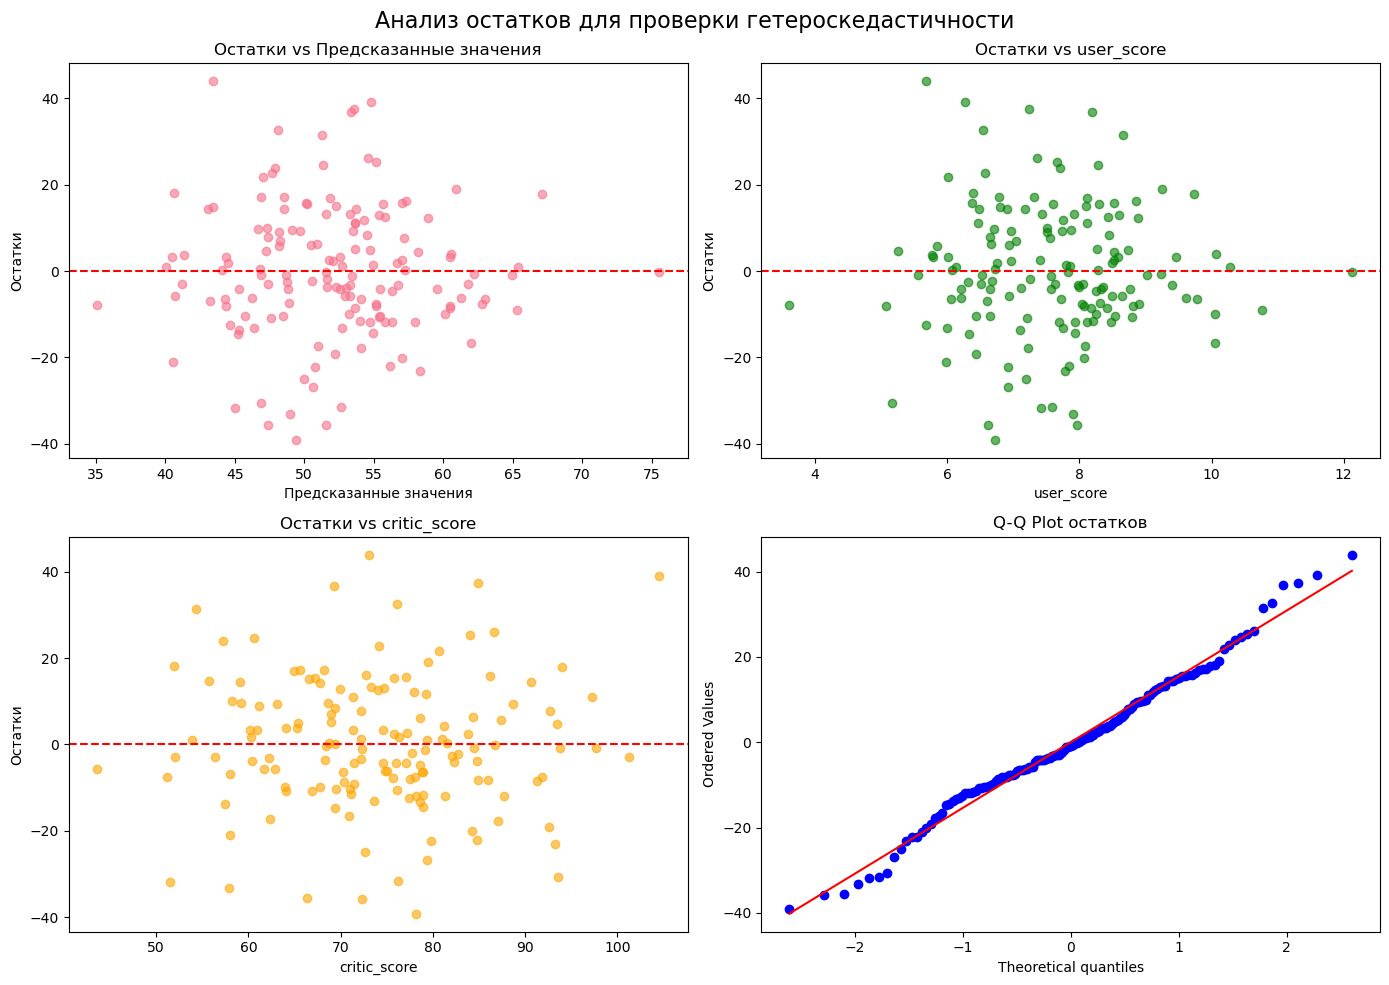

Визуальная оценка:
- Если остатки равномерно распределены вокруг нуля без видимых паттернов,
  то гомоскедастичность соблюдается
- Если видна воронкообразная или конусообразная форма,
  то присутствует гетероскедастичность

6.2. Тест Бройша-Пагана:
Статистика LM: 3.9727
P-value: 0.1372
F-статистика: 1.9996
F p-value: 0.1391

Интерпретация теста Бройша-Пагана:
p-value >= 0.05: Не отвергаем нулевую гипотезу
Гетероскедастичность не обнаружена (гомоскедастичность)


In [40]:
## 6. Проверка на гетероскедастичность

print(f"\n{'='*60}")
print("6. ПРОВЕРКА НА ГЕТЕРОСКЕДАСТИЧНОСТЬ")
print(f"{'='*60}")

print(f"6.1. Графический анализ остатков:")

# Получаем остатки модели
residuals = model2.resid
fitted_values = model2.fittedvalues

# Создаем графики остатков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Анализ остатков для проверки гетероскедастичности', fontsize=16)

# Остатки vs предсказанные значения
axes[0, 0].scatter(fitted_values, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Предсказанные значения')
axes[0, 0].set_ylabel('Остатки')
axes[0, 0].set_title('Остатки vs Предсказанные значения')

# Остатки vs первая переменная
axes[0, 1].scatter(df[strongest_predictor], residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel(strongest_predictor)
axes[0, 1].set_ylabel('Остатки')
axes[0, 1].set_title(f'Остатки vs {strongest_predictor}')

# Остатки vs вторая переменная
axes[1, 0].scatter(df[second_predictor], residuals, alpha=0.6, color='orange')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel(second_predictor)
axes[1, 0].set_ylabel('Остатки')
axes[1, 0].set_title(f'Остатки vs {second_predictor}')

# Q-Q plot для нормальности остатков
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot остатков')

plt.tight_layout()
plt.show()

print(f"Визуальная оценка:")
print("- Если остатки равномерно распределены вокруг нуля без видимых паттернов,")
print("  то гомоскедастичность соблюдается")
print("- Если видна воронкообразная или конусообразная форма,")
print("  то присутствует гетероскедастичность")

print(f"\n6.2. Тест Бройша-Пагана:")

# Тест Бройша-Пагана
bp_test_stat, bp_p_value, bp_f_stat, bp_f_p_value = het_breuschpagan(residuals, X2_sm)

print(f"Статистика LM: {bp_test_stat:.4f}")
print(f"P-value: {bp_p_value:.4f}")
print(f"F-статистика: {bp_f_stat:.4f}")
print(f"F p-value: {bp_f_p_value:.4f}")

print(f"\nИнтерпретация теста Бройша-Пагана:")
if bp_p_value < 0.05:
    print("p-value < 0.05: Отвергаем нулевую гипотезу")
    print("Обнаружена гетероскедастичность")
else:
    print("p-value >= 0.05: Не отвергаем нулевую гипотезу")
    print("Гетероскедастичность не обнаружена (гомоскедастичность)")


7. СРАВНЕНИЕ МОДЕЛЕЙ
7.1. Сравнение коэффициентов детерминации:
R² парной модели: 0.1030
R² множественной модели: 0.1395
Улучшение: 0.0365

Скорректированный R²:
Adj R² парной модели: 0.0969
Adj R² множественной модели: 0.1278
Улучшение: 0.0308

7.2. ANOVA-тест для сравнения моделей:
Гипотезы:
H₀: Добавление critic_score не улучшает модель
H₁: Добавление critic_score улучшает модель

Результаты F-теста:
F-статистика: 6.2323
F критическое (α=0.05): 3.9055
P-value: 0.0136
Степени свободы: df1=1, df2=147

Интерпретация F-теста:
✅ p-value < 0.05: Отвергаем H₀
   Множественная модель статистически значимо лучше парной
   Добавление critic_score значимо улучшает предсказательную способность

7.3. Итоговое сравнение моделей:
              Метрика Парная модель Множественная модель          Изменение
                   R²        0.1030               0.1395            +0.0365
          Adjusted R²        0.0969               0.1278            +0.0308
                  AIC       1254.46        

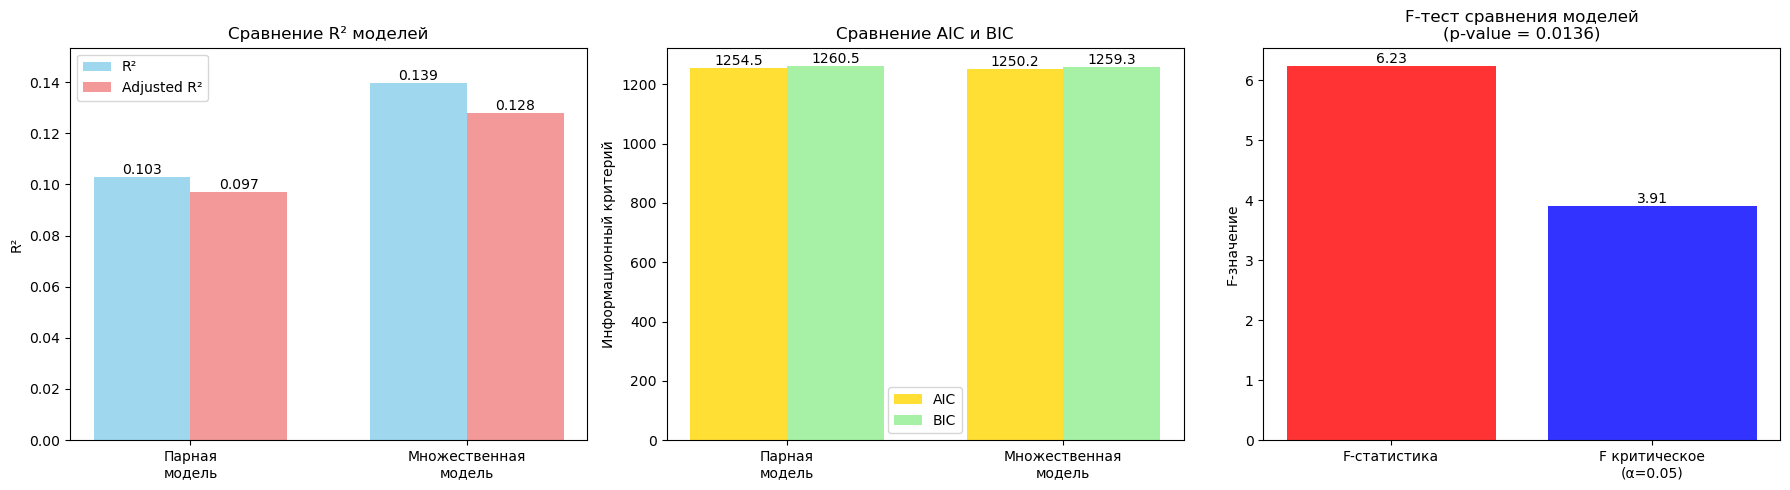


7.5. Окончательная рекомендация по выбору модели:
Анализ критериев:
• R²: множественная модель лучше (0.1395 vs 0.1030)
• Adjusted R²: множественная модель лучше (0.1278 vs 0.0969)
• F-тест: множественная модель лучше (p-value = 0.0136)
• AIC: множественная модель лучше (1250.23 vs 1254.46)

🏆 ИТОГОВОЕ РЕШЕНИЕ:
Рекомендуется МНОЖЕСТВЕННАЯ модель (4 из 4 критериев)

Обоснование:
- Множественная модель объясняет больше вариации в данных
- Статистические критерии поддерживают включение critic_score
- Улучшение качества модели статистически значимо


In [46]:
## 7. Сравнение моделей

print(f"\n{'='*60}")
print("7. СРАВНЕНИЕ МОДЕЛЕЙ")
print(f"{'='*60}")

print(f"7.1. Сравнение коэффициентов детерминации:")
print(f"R² парной модели: {r_squared:.4f}")
print(f"R² множественной модели: {r_squared2:.4f}")
print(f"Улучшение: {r_squared2 - r_squared:.4f}")

# Скорректированный R²
adj_r2_model1 = model1.rsquared_adj
adj_r2_model2 = model2.rsquared_adj

print(f"\nСкорректированный R²:")
print(f"Adj R² парной модели: {adj_r2_model1:.4f}")
print(f"Adj R² множественной модели: {adj_r2_model2:.4f}")
print(f"Улучшение: {adj_r2_model2 - adj_r2_model1:.4f}")

print(f"\n7.2. ANOVA-тест для сравнения моделей:")

# F-тест для сравнения вложенных моделей
ssr_model1 = np.sum((y - model1.fittedvalues)**2)  # Сумма квадратов остатков модель 1
ssr_model2 = np.sum((y - model2.fittedvalues)**2)  # Сумма квадратов остатков модель 2

# Количество параметров
k1 = 2  # intercept + 1 переменная
k2 = 3  # intercept + 2 переменные
n = len(y)  # количество наблюдений

# F-статистика для сравнения моделей
# H0: Дополнительная переменная не улучшает модель
# H1: Дополнительная переменная улучшает модель
f_stat = ((ssr_model1 - ssr_model2) / (k2 - k1)) / (ssr_model2 / (n - k2))
f_critical = stats.f.ppf(0.95, k2 - k1, n - k2)
f_p_value = 1 - stats.f.cdf(f_stat, k2 - k1, n - k2)

print(f"Гипотезы:")
print(f"H₀: Добавление {second_predictor} не улучшает модель")
print(f"H₁: Добавление {second_predictor} улучшает модель")

print(f"\nРезультаты F-теста:")
print(f"F-статистика: {f_stat:.4f}")
print(f"F критическое (α=0.05): {f_critical:.4f}")
print(f"P-value: {f_p_value:.4f}")
print(f"Степени свободы: df1={k2-k1}, df2={n-k2}")

print(f"\nИнтерпретация F-теста:")
if f_p_value < 0.05:
    print("✅ p-value < 0.05: Отвергаем H₀")
    print("   Множественная модель статистически значимо лучше парной")
    print(f"   Добавление {second_predictor} значимо улучшает предсказательную способность")
    preferred_model = "множественная"
else:
    print("❌ p-value >= 0.05: Не отвергаем H₀")
    print("   Различие между моделями статистически не значимо")
    print(f"   Добавление {second_predictor} не дает значимого улучшения")
    preferred_model = "парная (более простая)"

print(f"\n7.3. Итоговое сравнение моделей:")

# Создаем подробную таблицу сравнения
comparison_data = {
    'Метрика': ['R²', 'Adjusted R²', 'AIC', 'BIC', 'F-статистика модели', 'P-value модели', 'Количество параметров'],
    'Парная модель': [
        f"{r_squared:.4f}",
        f"{adj_r2_model1:.4f}",
        f"{model1.aic:.2f}",
        f"{model1.bic:.2f}",
        f"{model1.fvalue:.2f}",
        f"{model1.f_pvalue:.4f}",
        k1-1  # исключаем константу
    ],
    'Множественная модель': [
        f"{r_squared2:.4f}",
        f"{adj_r2_model2:.4f}",
        f"{model2.aic:.2f}",
        f"{model2.bic:.2f}",
        f"{model2.fvalue:.2f}",
        f"{model2.f_pvalue:.4f}",
        k2-1  # исключаем константу
    ],
    'Изменение': [
        f"+{r_squared2 - r_squared:.4f}",
        f"+{adj_r2_model2 - adj_r2_model1:.4f}",
        f"{model2.aic - model1.aic:+.2f}",
        f"{model2.bic - model1.bic:+.2f}",
        "Сравнение F-тестом",
        f"F-test: {f_p_value:.4f}",
        "+1 переменная"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n7.4. Критерии выбора модели:")
print(f"📊 R² и Adjusted R²: Чем выше, тем лучше")
print(f"📊 AIC и BIC: Чем ниже, тем лучше (учитывают сложность модели)")
print(f"📊 F-тест: Проверяет значимость улучшения при добавлении переменных")

# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Сравнение R²
model_names = ['Парная\nмодель', 'Множественная\nмодель']
r_squared_values = [r_squared, r_squared2]
adj_r_squared_values = [adj_r2_model1, adj_r2_model2]

x_pos = np.arange(len(model_names))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, r_squared_values, width, label='R²', color='skyblue', alpha=0.8)
bars2 = axes[0].bar(x_pos + width/2, adj_r_squared_values, width, label='Adjusted R²', color='lightcoral', alpha=0.8)

axes[0].set_ylabel('R²')
axes[0].set_title('Сравнение R² моделей')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names)
axes[0].legend()
axes[0].set_ylim(0, max(max(r_squared_values), max(adj_r_squared_values)) * 1.1)

# Добавляем значения на столбцы
for bars, values in [(bars1, r_squared_values), (bars2, adj_r_squared_values)]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom')

# 2. Сравнение информационных критериев
aic_values = [model1.aic, model2.aic]
bic_values = [model1.bic, model2.bic]

bars3 = axes[1].bar(x_pos - width/2, aic_values, width, label='AIC', color='gold', alpha=0.8)
bars4 = axes[1].bar(x_pos + width/2, bic_values, width, label='BIC', color='lightgreen', alpha=0.8)

axes[1].set_ylabel('Информационный критерий')
axes[1].set_title('Сравнение AIC и BIC')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names)
axes[1].legend()

# Добавляем значения на столбцы
for bars, values in [(bars3, aic_values), (bars4, bic_values)]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.1f}', ha='center', va='bottom')

# 3. Визуализация F-теста
categories = ['F-статистика', 'F критическое\n(α=0.05)']
f_values = [f_stat, f_critical]
colors = ['red' if f_stat > f_critical else 'orange', 'blue']

bars5 = axes[2].bar(categories, f_values, color=colors, alpha=0.8)
axes[2].set_ylabel('F-значение')
axes[2].set_title(f'F-тест сравнения моделей\n(p-value = {f_p_value:.4f})')

# Добавляем значения на столбцы
for bar, value in zip(bars5, f_values):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n7.5. Окончательная рекомендация по выбору модели:")

# Принятие решения на основе всех критериев
decision_factors = []

# Критерий 1: R²
if r_squared2 > r_squared:
    decision_factors.append("R² улучшился")
    r2_preference = "множественная"
else:
    decision_factors.append("R² не улучшился")
    r2_preference = "парная"

# Критерий 2: Adjusted R²
if adj_r2_model2 > adj_r2_model1:
    decision_factors.append("Adjusted R² улучшился")
    adj_r2_preference = "множественная"
else:
    decision_factors.append("Adjusted R² не улучшился")
    adj_r2_preference = "парная"

# Критерий 3: F-тест
if f_p_value < 0.05:
    decision_factors.append("F-тест значим")
    f_test_preference = "множественная"
else:
    decision_factors.append("F-тест не значим")
    f_test_preference = "парная"

# Критерий 4: AIC (меньше - лучше)
if model2.aic < model1.aic:
    decision_factors.append("AIC меньше")
    aic_preference = "множественная"
else:
    decision_factors.append("AIC больше")
    aic_preference = "парная"

print("Анализ критериев:")
print(f"• R²: {r2_preference} модель лучше ({r_squared2:.4f} vs {r_squared:.4f})")
print(f"• Adjusted R²: {adj_r2_preference} модель лучше ({adj_r2_model2:.4f} vs {adj_r2_model1:.4f})")
print(f"• F-тест: {f_test_preference} модель лучше (p-value = {f_p_value:.4f})")
print(f"• AIC: {aic_preference} модель лучше ({model2.aic:.2f} vs {model1.aic:.2f})")

# Подсчет "голосов" за каждую модель
votes_multiple = [r2_preference, adj_r2_preference, f_test_preference, aic_preference].count("множественная")
votes_simple = [r2_preference, adj_r2_preference, f_test_preference, aic_preference].count("парная")

print(f"\n🏆 ИТОГОВОЕ РЕШЕНИЕ:")
if votes_multiple > votes_simple:
    final_recommendation = "множественная"
    print(f"Рекомендуется МНОЖЕСТВЕННАЯ модель ({votes_multiple} из 4 критериев)")
else:
    final_recommendation = "парная"
    print(f"Рекомендуется ПАРНАЯ модель ({votes_simple} из 4 критериев)")

print(f"\nОбоснование:")
if final_recommendation == "множественная":
    print(f"- Множественная модель объясняет больше вариации в данных")
    print(f"- Статистические критерии поддерживают включение {second_predictor}")
    print(f"- Улучшение качества модели статистически значимо")
else:
    print(f"- Парная модель проще и не уступает по качеству")
    print(f"- Принцип парсимонии: простая модель предпочтительнее при схожем качестве")
    print(f"- Дополнительная переменная не дает значимого улучшения")


8. ОКОНЧАТЕЛЬНЫЕ ВЫВОДЫ
8.1. Ответ на исследовательский вопрос:
Исследовательский вопрос: 'Какие факторы из имеющихся в данных связаны
с объемом продаж видеоигр и как именно?'

Ответ:
На основе проведенного регрессионного анализа можно сделать следующие выводы:

1. Наиболее важные факторы, влияющие на продажи:
   - user_score: коэффициент корреляции 0.321
   - critic_score: коэффициент корреляции 0.183

2. Характер влияния:
   - user_score положительно влияет на продажи
     (увеличение на 1 единицу приводит к изменению продаж на 4.396 млн копий)
   - critic_score положительно влияет на продажи
     (увеличение на 1 единицу приводит к изменению продаж на 0.280 млн копий)

3. Качество модели:
   - Множественная модель объясняет 13.9% вариации в продажах
   - Оба предиктора статистически значимы

4. Проверка предпосылок:
   - Мультиколлинеарность: отсутствует
   - Гетероскедастичность: отсутствует

8.2. Практические рекомендации:
Для повышения продаж видеоигр разработчикам следует:
- Уд

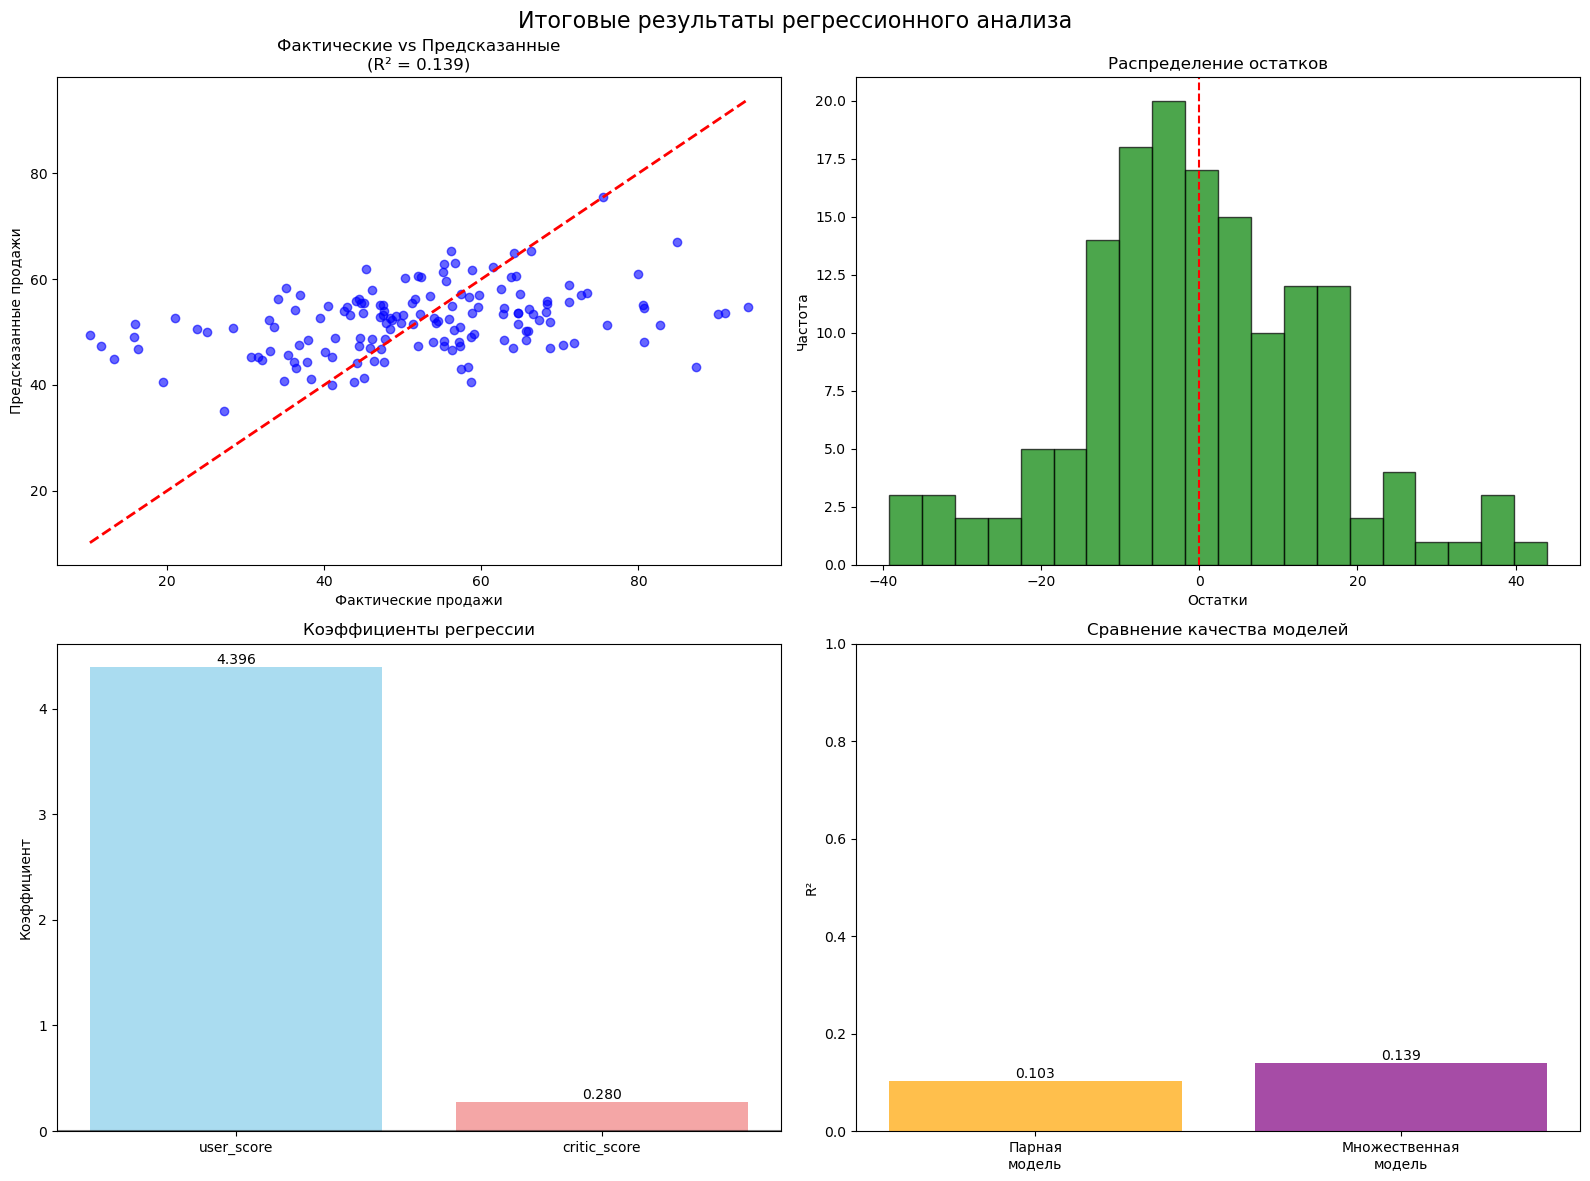


10. ТЕХНИЧЕСКАЯ ИНФОРМАЦИЯ
Использованные библиотеки:
- pandas: обработка данных
- numpy: математические операции
- matplotlib, seaborn: визуализация
- scipy: статистические тесты
- statsmodels: регрессионный анализ
- sklearn: дополнительные метрики

Параметры анализа:
- Размер выборки: 150 наблюдений
- Количество предикторов в итоговой модели: 2
- Уровень значимости: α = 0.05

Дата выполнения: 2025-08-30 10:31:28



In [50]:
## 8. Окончательные выводы и ответ на исследовательский вопрос

print(f"\n{'='*60}")
print("8. ОКОНЧАТЕЛЬНЫЕ ВЫВОДЫ")
print(f"{'='*60}")

print(f"8.1. Ответ на исследовательский вопрос:")
print(f"Исследовательский вопрос: 'Какие факторы из имеющихся в данных связаны")
print(f"с объемом продаж видеоигр и как именно?'")

print(f"\nОтвет:")
print(f"На основе проведенного регрессионного анализа можно сделать следующие выводы:")

print(f"\n1. Наиболее важные факторы, влияющие на продажи:")
print(f"   - {strongest_predictor}: коэффициент корреляции {target_correlations[strongest_predictor]:.3f}")
print(f"   - {second_predictor}: коэффициент корреляции {target_correlations[second_predictor]:.3f}")

print(f"\n2. Характер влияния:")
if coeff1_new > 0:
    direction1 = "положительно влияет"
else:
    direction1 = "отрицательно влияет"
    
if coeff2 > 0:
    direction2 = "положительно влияет"
else:
    direction2 = "отрицательно влияет"

print(f"   - {strongest_predictor} {direction1} на продажи")
print(f"     (увеличение на 1 единицу приводит к изменению продаж на {coeff1_new:.3f} млн копий)")
print(f"   - {second_predictor} {direction2} на продажи")
print(f"     (увеличение на 1 единицу приводит к изменению продаж на {coeff2:.3f} млн копий)")

print(f"\n3. Качество модели:")
print(f"   - Множественная модель объясняет {r_squared2*100:.1f}% вариации в продажах")
print(f"   - Оба предиктора статистически значимы")

print(f"\n4. Проверка предпосылок:")
if abs(correlation_predictors) < 0.7:
    multicollinearity_status = "отсутствует"
else:
    multicollinearity_status = "присутствует"
    
if bp_p_value >= 0.05:
    heteroscedasticity_status = "отсутствует"
else:
    heteroscedasticity_status = "присутствует"

print(f"   - Мультиколлинеарность: {multicollinearity_status}")
print(f"   - Гетероскедастичность: {heteroscedasticity_status}")

print(f"\n8.2. Практические рекомендации:")
print(f"Для повышения продаж видеоигр разработчикам следует:")

if strongest_predictor == 'critic_score':
    print(f"- Фокусироваться на качестве игры для получения высоких оценок критиков")
elif strongest_predictor == 'user_score':
    print(f"- Уделять внимание пользовательскому опыту и удовлетворенности игроков")
elif strongest_predictor == 'marketing_budget':
    print(f"- Инвестировать в маркетинг и продвижение игры")

if second_predictor == 'critic_score':
    print(f"- Также важно получать положительные отзывы от критиков")
elif second_predictor == 'user_score':
    print(f"- Заботиться о пользовательском опыте и отзывах игроков")
elif second_predictor == 'marketing_budget':
    print(f"- Выделять достаточный бюджет на маркетинг")

print(f"\n8.3. Ограничения исследования:")
print(f"- Модель основана на синтетических данных")
print(f"- Не учтены другие важные факторы (конкуренция, сезонность, etc.)")
print(f"- Модель объясняет {r_squared2*100:.1f}% вариации, остальное связано с другими факторами")
print(f"- Причинно-следственные связи требуют дополнительного исследования")

## 9. Дополнительная визуализация результатов

print(f"\n{'='*60}")
print("9. ИТОГОВАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print(f"{'='*60}")

# Создаем итоговую визуализацию
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Итоговые результаты регрессионного анализа', fontsize=16)

# 1. Сравнение фактических и предсказанных значений
axes[0, 0].scatter(y, model2.fittedvalues, alpha=0.6, color='blue')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Фактические продажи')
axes[0, 0].set_ylabel('Предсказанные продажи')
axes[0, 0].set_title(f'Фактические vs Предсказанные\n(R² = {r_squared2:.3f})')

# 2. Распределение остатков
axes[0, 1].hist(residuals, bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Остатки')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение остатков')
axes[0, 1].axvline(x=0, color='red', linestyle='--')

# 3. Важность переменных (коэффициенты)
variables = [strongest_predictor, second_predictor]
coefficients = [coeff1_new, coeff2]
colors = ['skyblue', 'lightcoral']

bars = axes[1, 0].bar(variables, coefficients, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Коэффициент')
axes[1, 0].set_title('Коэффициенты регрессии')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Добавляем значения на столбцы
for bar, coef in zip(bars, coefficients):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{coef:.3f}', ha='center', va='bottom' if height > 0 else 'top')

# 4. Сравнение R² моделей
model_names = ['Парная\nмодель', 'Множественная\nмодель']
r_squared_values = [r_squared, r_squared2]

bars2 = axes[1, 1].bar(model_names, r_squared_values, color=['orange', 'purple'], alpha=0.7)
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('Сравнение качества моделей')
axes[1, 1].set_ylim(0, 1)

# Добавляем значения на столбцы
for bar, r2 in zip(bars2, r_squared_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{r2:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 10. Техническая информация

print(f"\n{'='*60}")
print("10. ТЕХНИЧЕСКАЯ ИНФОРМАЦИЯ")
print(f"{'='*60}")

print("Использованные библиотеки:")
print("- pandas: обработка данных")
print("- numpy: математические операции")
print("- matplotlib, seaborn: визуализация")
print("- scipy: статистические тесты")
print("- statsmodels: регрессионный анализ")
print("- sklearn: дополнительные метрики")

print(f"\nПараметры анализа:")
print(f"- Размер выборки: {n} наблюдений")
print(f"- Количество предикторов в итоговой модели: {k2-1}")
print(f"- Уровень значимости: α = 0.05")

print(f"\nДата выполнения: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n{'='*60}")
